In [1]:
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm_notebook
from sklearn.metrics import f1_score, precision_score, recall_score
import matplotlib.pyplot as plt
import torchvision.transforms as T
import datasets
import torch
import torchvision
import numpy as np

In [2]:
# Set device
device = "cpu"
if torch.backends.mps.is_available():
    device = "mps"
elif torch.cuda_is_available():
    device = "cuda"

device = torch.device(device)

#Set Parameters for creating the Dataset
num_workers = 0
crop_size = 625
resize = 360
batch_size = 32

In [3]:
def to_3_channels(image):
    if image.shape[0] == 3:
        return image
    elif image.shape[0] == 1:
        return image.repeat(3, 1, 1)
    else:
        # Select the first 3 channels if the input has more than 3 channels
        return image[:3, :, :]

def collate_fn(examples):
    images, labels = [], []

    image_transform = T.Compose([
            T.RandomCrop(crop_size, pad_if_needed=True),
            T.Resize((resize,resize)),
            T.ToTensor(),
            T.Lambda(to_3_channels),
            T.RandomHorizontalFlip(p=0.5),
            T.RandomVerticalFlip(p=0.5),
            T.RandomApply([T.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5))], p=0.5),
            T.RandomGrayscale(p=0.5),
            T.RandomErasing(p=0.2, scale=(0.02, 0.2))
        ])

    # Iterate through the examples, apply the image transformation, and append the results
    for example in examples:
        image = image_transform(example['image'])
        label = example['label']
        images.append(image)
        labels.append(label)

        pixel_values = torch.stack(images)
    labels = torch.tensor(labels)

    return {"pixel_values": pixel_values, "label": labels}

test_dataset = datasets.load_dataset("Hanneseh/MPDL_Project_1_custom_data", split="test")
test_dataloader = DataLoader(test_dataset, collate_fn=collate_fn, batch_size=batch_size, num_workers=num_workers, shuffle=True)

Found cached dataset imagefolder (/Users/pauladler/.cache/huggingface/datasets/Hanneseh___imagefolder/Hanneseh--MPDL_Project_1_custom_data-b0234636f7e76ba6/0.0.0/37fbb85cc714a338bea574ac6c7d0b5be5aff46c1862c1989b20e0771199e93f)


In [4]:
class customThreshold(torch.nn.Module):
    def __init__(self, fake_label, threshold):
        super(customThreshold, self).__init__()
        self.fake_label = fake_label
        self.threshold = threshold

    def forward(self, x):
        prob = torch.sigmoid(x[:, self.fake_label]) # extract probability of fake
        pred = (prob >= self.threshold).float() # threshold probability
        return (prob.view(-1, 1), pred.view(-1, 1))

PATH = '../models/resnet50_dataset_3_lr_0_0001_final.pth'

thresholds = np.around(np.arange(0, 1.05, 0.05), decimals=2)
print(thresholds)
accuracy_arr, f1_arr, precision_arr, recall_arr = [], [], [], []

for threshold in thresholds:
    print(f"THRESHOLD: {threshold}")
    model = torchvision.models.resnet50(pretrained=True)
    model.fc = torch.nn.Linear(model.fc.in_features, 2)
    model.load_state_dict(torch.load(PATH, map_location=device))
    model.fc = torch.nn.Sequential(model.fc, customThreshold(1, threshold))
    model.eval()
    with torch.no_grad():
        model = torch.jit.trace(model, torch.randn(1, 3, 360, 360))
    model = model.to(device)

    correct, total, test_loss = 0, 0, 0
    all_labels, all_predicted = [], []

    with torch.no_grad():
        for element in tqdm_notebook(test_dataloader):
            inputs = element["pixel_values"].to(device)
            labels = element["label"].to(device)

            predicted = torch.squeeze(model(inputs)[1])

            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            
            all_labels.extend(labels.cpu().numpy())
            all_predicted.extend(predicted.cpu().numpy())
            
    accuracy_arr.append(100. * correct / total)
    f1_arr.append(f1_score(all_labels, all_predicted, average='binary'))
    precision_arr.append(precision_score(all_labels, all_predicted, average='binary'))
    recall_arr.append(recall_score(all_labels, all_predicted, average='binary'))

/Users/pauladler/MPDL_Project_1/.venv/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/pauladler/MPDL_Project_1/.venv/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


[0.   0.05 0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5  0.55 0.6  0.65
 0.7  0.75 0.8  0.85 0.9  0.95 1.  ]
THRESHOLD: 0.0


  0%|          | 0/500 [00:00<?, ?it/s]

THRESHOLD: 0.05


/Users/pauladler/MPDL_Project_1/.venv/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/pauladler/MPDL_Project_1/.venv/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


  0%|          | 0/500 [00:00<?, ?it/s]

THRESHOLD: 0.1


/Users/pauladler/MPDL_Project_1/.venv/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/pauladler/MPDL_Project_1/.venv/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


  0%|          | 0/500 [00:00<?, ?it/s]

THRESHOLD: 0.15


/Users/pauladler/MPDL_Project_1/.venv/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/pauladler/MPDL_Project_1/.venv/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


  0%|          | 0/500 [00:00<?, ?it/s]

THRESHOLD: 0.2


/Users/pauladler/MPDL_Project_1/.venv/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/pauladler/MPDL_Project_1/.venv/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


  0%|          | 0/500 [00:00<?, ?it/s]

THRESHOLD: 0.25


/Users/pauladler/MPDL_Project_1/.venv/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/pauladler/MPDL_Project_1/.venv/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


  0%|          | 0/500 [00:00<?, ?it/s]

THRESHOLD: 0.3


/Users/pauladler/MPDL_Project_1/.venv/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/pauladler/MPDL_Project_1/.venv/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


  0%|          | 0/500 [00:00<?, ?it/s]

THRESHOLD: 0.35


/Users/pauladler/MPDL_Project_1/.venv/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/pauladler/MPDL_Project_1/.venv/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


  0%|          | 0/500 [00:00<?, ?it/s]

THRESHOLD: 0.4


/Users/pauladler/MPDL_Project_1/.venv/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/pauladler/MPDL_Project_1/.venv/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


  0%|          | 0/500 [00:00<?, ?it/s]

THRESHOLD: 0.45


/Users/pauladler/MPDL_Project_1/.venv/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/pauladler/MPDL_Project_1/.venv/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


  0%|          | 0/500 [00:00<?, ?it/s]

THRESHOLD: 0.5


/Users/pauladler/MPDL_Project_1/.venv/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/pauladler/MPDL_Project_1/.venv/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


  0%|          | 0/500 [00:00<?, ?it/s]

THRESHOLD: 0.55


/Users/pauladler/MPDL_Project_1/.venv/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/pauladler/MPDL_Project_1/.venv/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


  0%|          | 0/500 [00:00<?, ?it/s]

THRESHOLD: 0.6


/Users/pauladler/MPDL_Project_1/.venv/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/pauladler/MPDL_Project_1/.venv/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


  0%|          | 0/500 [00:00<?, ?it/s]

THRESHOLD: 0.65


/Users/pauladler/MPDL_Project_1/.venv/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/pauladler/MPDL_Project_1/.venv/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


  0%|          | 0/500 [00:00<?, ?it/s]

THRESHOLD: 0.7


/Users/pauladler/MPDL_Project_1/.venv/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/pauladler/MPDL_Project_1/.venv/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


  0%|          | 0/500 [00:00<?, ?it/s]

THRESHOLD: 0.75


/Users/pauladler/MPDL_Project_1/.venv/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/pauladler/MPDL_Project_1/.venv/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


  0%|          | 0/500 [00:00<?, ?it/s]

THRESHOLD: 0.8


/Users/pauladler/MPDL_Project_1/.venv/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/pauladler/MPDL_Project_1/.venv/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


  0%|          | 0/500 [00:00<?, ?it/s]

THRESHOLD: 0.85


/Users/pauladler/MPDL_Project_1/.venv/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/pauladler/MPDL_Project_1/.venv/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


  0%|          | 0/500 [00:00<?, ?it/s]

THRESHOLD: 0.9


/Users/pauladler/MPDL_Project_1/.venv/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/pauladler/MPDL_Project_1/.venv/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


  0%|          | 0/500 [00:00<?, ?it/s]

THRESHOLD: 0.95


/Users/pauladler/MPDL_Project_1/.venv/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/pauladler/MPDL_Project_1/.venv/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


  0%|          | 0/500 [00:00<?, ?it/s]

THRESHOLD: 1.0


/Users/pauladler/MPDL_Project_1/.venv/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/pauladler/MPDL_Project_1/.venv/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


  0%|          | 0/500 [00:00<?, ?it/s]

/Users/pauladler/MPDL_Project_1/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


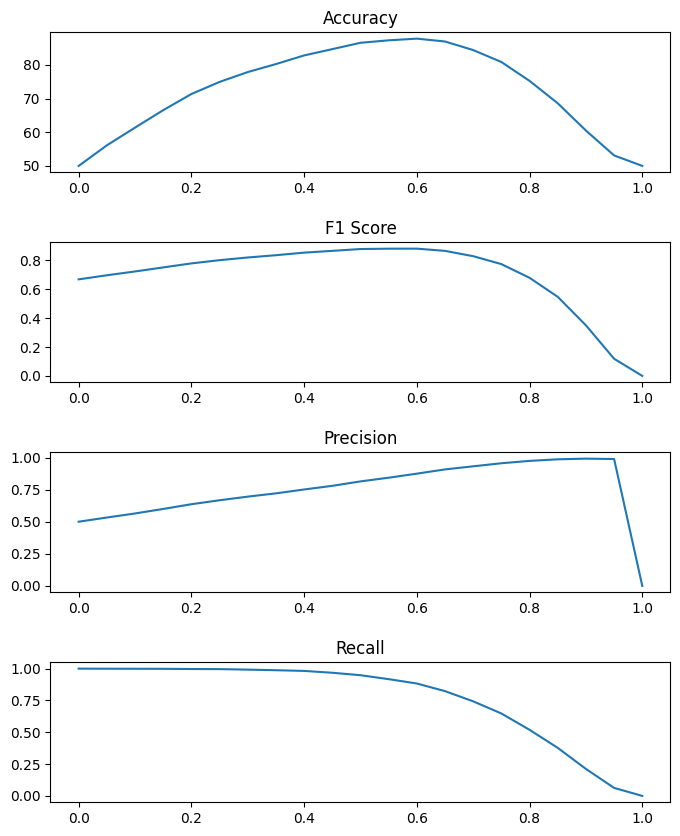

In [5]:
fig, axs = plt.subplots(4, 1, figsize=(8, 10))

axs[0].plot(thresholds, accuracy_arr)
axs[0].set_title('Accuracy')
axs[1].plot(thresholds, f1_arr)
axs[1].set_title('F1 Score')
axs[2].plot(thresholds, precision_arr)
axs[2].set_title('Precision')
axs[3].plot(thresholds, recall_arr)
axs[3].set_title('Recall')
plt.subplots_adjust(hspace=0.5)

plt.show()